# Homework 08 - PCA and Clustering Key (60 pts)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

---
### EEG dataset

The following cell will load and parse an EEG dataset for you.

The dataset is located in the time series lecture folder. If you put it somewhere else on your computer, just change the path so that it points to where you have placed the sampleEEGdata.mat file.

In [110]:
# this cell loads a bunch of EEG data for you
# you don't have to edit it, just run it to get the data
import numpy as np
from scipy.io import loadmat

# data file is in the time series lecture folder
data = loadmat('lecture_25_time_series/sampleEEGdata.mat')

# grab relevant data, EEG units are microvolts (uV)
# each channel is an electrode, each trial is a separate EEG recording from that electrode
eeg_uV = data["EEG"][0,0]["data"]  # [channel, time, trial]
time_ms = data["EEG"][0,0]["times"][0]
samplefreq_Hz = float(data["EEG"][0,0]["srate"][0])
dt_ms = time_ms[1] - time_ms[0]
n_channels = eeg_uV.shape[0]
n_pts = eeg_uV.shape[1]
n_trials = eeg_uV.shape[2]

# put all EEG waveforms from all channels and all trials into one big matrix
# rows are waveforms, columns are time points
n_eegs = n_channels * n_trials
all_eegs_uV = np.zeros((n_eegs, n_pts))
avg_eegs_uV = np.zeros((n_channels, n_pts))  # average EEG per channel
channels = np.zeros((n_eegs,), dtype=int)
i = 0
for c in range(n_channels):
    avg_eegs_uV[c, :] = eeg_uV[c, :, :].mean(axis=1)
    for t in range(n_trials):
        all_eegs_uV[i, :] = eeg_uV[c, :, t]
        channels[i] = c
        i += 1

all_eegs_uV.shape, avg_eegs_uV.shape, eeg_uV.shape, time_ms.shape, samplefreq_Hz, dt_ms

((6336, 640), (64, 640), (64, 640, 99), (640,), 256.0, 3.90625)

---
### 1. (5 pts) Plot the average EEG recording from the first and last electrode channel. Use the **avg_eegs_uV** variable.

Each row of the variable **avg_eegs_uV** is the average EEG recording from one electrode. First and last electrode recordings are in the first and last rows of this variable.

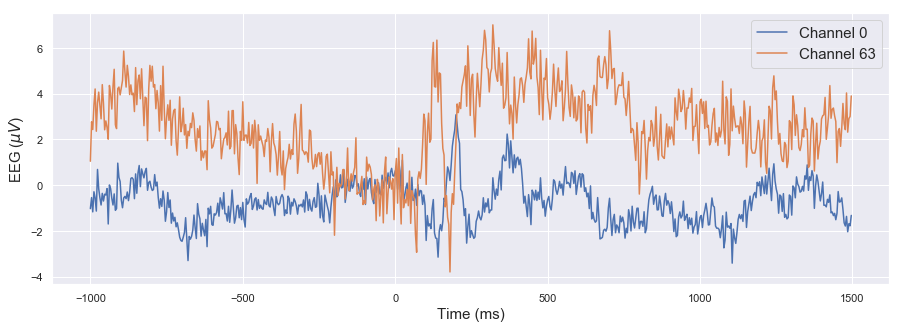

In [87]:
plt.figure(figsize=(15, 5))
plt.plot(time_ms, avg_eegs_uV[0, :], label='Channel 0')
plt.plot(time_ms, avg_eegs_uV[-1, :], label='Channel 63')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel(r'EEG ($\mu V$)', fontsize=15)
plt.legend(fontsize=15);

---
### 2. (5 pts) Perform Principal Component Analysis on the average EEG recordings from all electrodes such that 95% of the variability in the data is explained. Report the # of principal components required.

Note that each length 640 time point EEG recording is considered as a point in a 640-dimensional space.

In [111]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
pca.fit(avg_eegs_uV)

print(f'# principal componenets = {pca.n_components_}')

# principal componenets = 6


---
### 3. (5 pts) Transform the average EEGs into the lower dimensional PCA coordinates. Report the shape of the transformed EEG matrix and describe in your own words what the matrix represents.

In [113]:
transformed = pca.transform(avg_eegs_uV)

transformed.shape

(64, 6)

Each row of the transformed matrix is the representation of an EEG as a weighted mixture of the six principal components.

---
### 4. (5 pts) Plot the fraction of the explained variance versus the number of principal components. How much of the variability in the data are explained by the first two principal components?

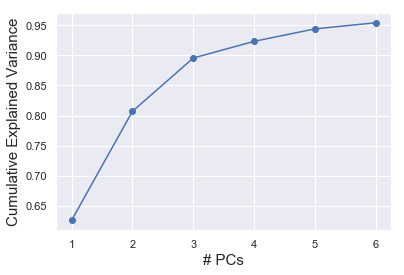

In [100]:
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs', fontsize=15)
plt.ylabel('Cumulative Explained Variance', fontsize=15);

In [116]:
print(f'The first two principal components explain {np.cumsum(pca.explained_variance_ratio_)[1] * 100:.1f}% of the variability in the data.')

The first two principal components explain 80.7% of the variability in the data.


---
### 5. (5 pts) Make a scatter plot of the PCA transformed EEGs projected onto the first two principal components (i.e. the scatter plot axes should be the first two principal components). Describe in your own words what each point on the scatter plot represents.

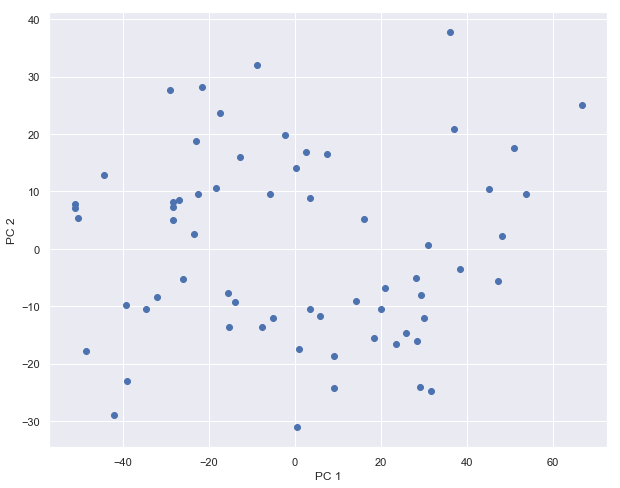

In [91]:
plt.figure(figsize=(10, 8))
plt.scatter(transformed[:, 0], transformed[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2');

Each point in the above scatter plot is an average EEG recording. It's position denotes the relative amounts of the first two principal components that should be mixed together to approximate the EEG.

---
### 6. (5 pts) Plot the first three principal components. Make sure to label the $x$-axis of the plot. Describe in your own words what the principal components represent.

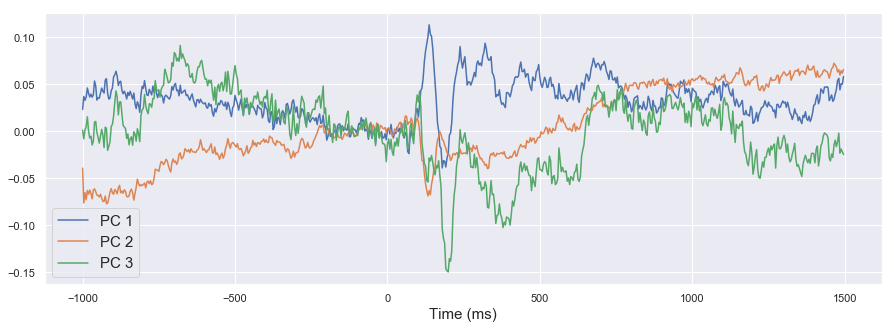

In [92]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.plot(time_ms, pca.components_[i], label=f'PC {i+1}')
plt.xlabel('Time (ms)', fontsize=15)
plt.legend(fontsize=15);

Each principal component is a waveform that contains a subset of the major features present in the EEG recordings. By mixing various amounts of the principal components, we can reproduce the original EEGs. The data loss that this process incurs depends on how many principal components we use and how much of the variability in the original EEG data they explain.

---
### 7. (5 pts) Transform back from PCA coordinates to the original EEG coordinates. Report the shape of the inverse transformed matrix and describe in your own words what the matrix represents.

In [117]:
projected = pca.inverse_transform(transformed)

projected.shape

(64, 640)

Each row of the projected matrix is a 640-time point duration average EEG recording represented as a mixture of only sixe principal componenets.

---
### 8. (pts) Plot the average EEG recording for the first electrode overlaid with its approximation from the PCA.

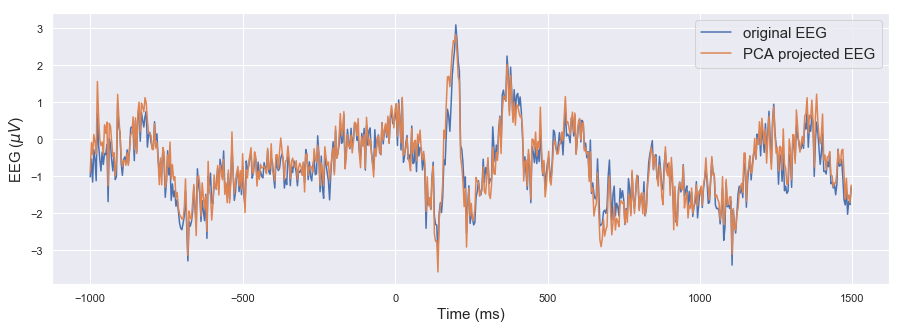

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(time_ms, avg_eegs_uV[0, :], label='original EEG')
plt.plot(time_ms, projected[0, :], label='PCA projected EEG')
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel(r'EEG ($\mu V$)', fontsize=15)
plt.legend(fontsize=15);

---
### 9. (10 pts) Use a Gaussian Mixture Model (GMM) to cluster the averge EEG recordings based on their PCA transformed representations. Repeat for 1 to 64 clusters and plot the Bayesian Information Criteria (BIC) versus number of clusters. Report the optimal number of clusters.

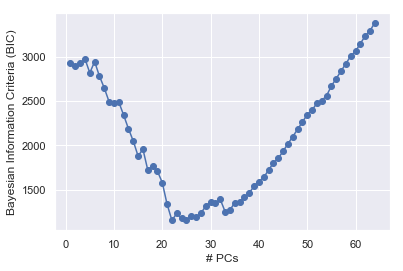

In [118]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 65)

gmms = [GaussianMixture(n, random_state=0) for n in n_components]

for gmm in gmms:
    gmm.fit(transformed)

bic = [gmm.bic(transformed) for gmm in gmms]

plt.plot(n_components, bic, 'o-', label='BIC')
plt.xlabel('# PCs');
plt.ylabel('Bayesian Information Criteria (BIC)');

In [119]:
n_components = n_components[np.argmin(bic)]

n_components

22

---
### 10. (5 pts) Use the optimal number of clusters above to recluster using a GMM. Make a scatter plot of the PCA transformed EEGs projected onto the first two principal components (i.e. the scatter plot axes should be the first two principal components). Color the points by their cluster index.

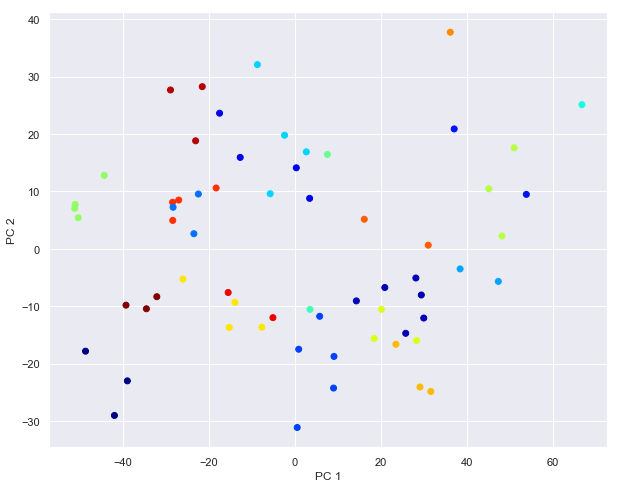

In [123]:
gmm = GaussianMixture(n_components, random_state=0)
gmm.fit(transformed)
cluster_labels = gmm.predict(transformed)

plt.figure(figsize=(10, 8))
plt.scatter(transformed[:, 0], transformed[:, 1], c=cluster_labels, cmap='jet')
plt.xlabel('PC 1')
plt.ylabel('PC 2');

---
### 11. (5 pts) For each of the first two clusters, plot overlaid all of the PCA-approximated EEGs belonging to that cluster.

Note that EEGs within clusters share similar features, whereas EEGs from different clusters have different features.

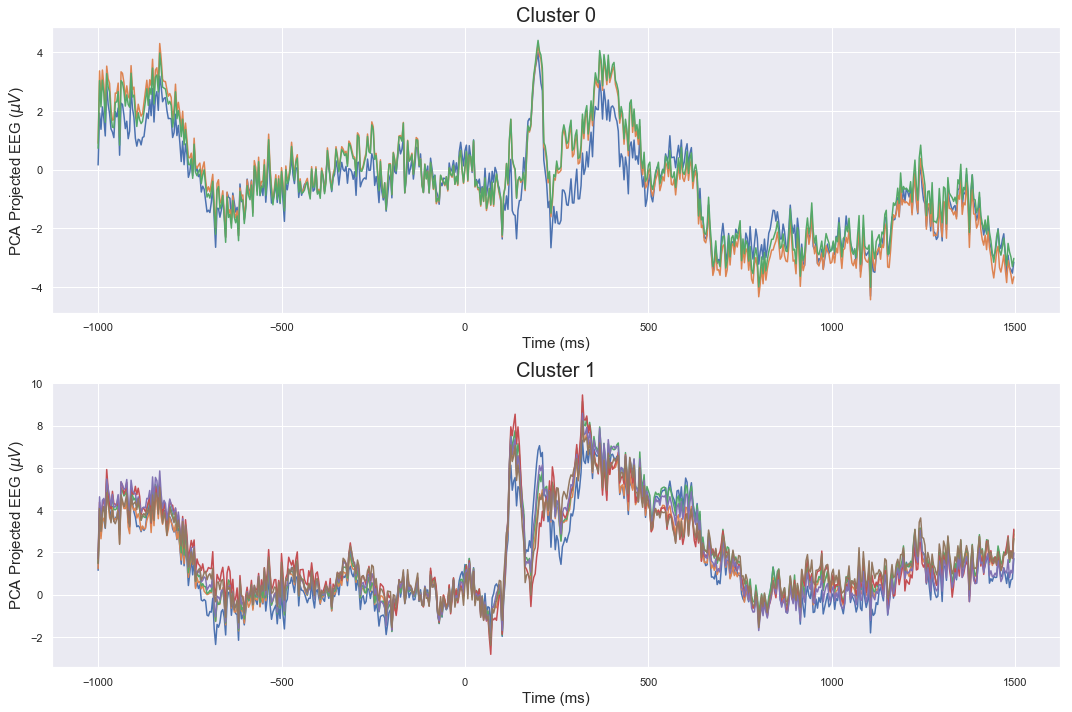

In [109]:
c0 = np.where(cluster_labels == 0)[0]
c1 = np.where(cluster_labels == 1)[0]

plt.figure(figsize=(15, 10))

plt.subplot(211)
for i in c0:
    plt.plot(time_ms, projected[i, :])
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel(r'PCA Projected EEG ($\mu V$)', fontsize=15)
plt.title('Cluster 0', fontsize=20)

plt.subplot(212)
for i in c1:
    plt.plot(time_ms, projected[i, :])
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel(r'PCA Projected EEG ($\mu V$)', fontsize=15)
plt.title('Cluster 1', fontsize=20)

plt.tight_layout();